In [135]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as ps
import matplotlib.pyplot as plt
import matplotlib as mpl

#For basemap:
import contextily as cx

#For regression:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices

import esda as esda
from esda.moran import Moran_Local
import splot as splot

#Plot spatial weights:
from libpysal.weights.contiguity import Queen
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot, plot_moran
from splot.esda import plot_local_autocorrelation

# For GWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

In [136]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [137]:
geogon_od = pd.read_csv('geogon_od.csv')
geogon_od 

# Rename our columns to have spaces 
geogon_od.columns = ['Year', 'FIPS', 'State', 'County', 'Deaths', 'Population', 'Crude_Rate',
       'Cruder_Rate', 'Deathrate_per_100', 'Unemployment_rate',
       'Dispense_rate', 'SUMLEV', 'AGEGRP', 'TOT_POP', 'TOT_MALE',
       'TOT_FEMALE', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE',
       'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE',
       'TOM_FEMALE', 'NH_MALE', 'NH_FEMALE', 'H_MALE', 'H_FEMALE',
       'Urbanicity', 'Jail_Population', 'Incarceration_Rate_per_100k',
       'PovertyCount', 'PovertyPercentage', 'MedianHHI', 'Latitude',
       'Longitude', 'geometry']


#
nonnum_features = ['Year', 'FIPS', 'State', 'County', 'Urbanicity', 'Latitude',
                   'Longitude', 'geometry']
stzd_geogon = standardize(geogon_od.drop(nonnum_features, axis = 1))
stzd_geogon[nonnum_features] = geogon_od[nonnum_features]
stzd_geogon





# Convert to geopandas 
# geogon_od = gpd.GeoDataFrame(geogon_od)
stzd_geogon['geometry'] = gpd.GeoSeries.from_wkt(stzd_geogon['geometry'])
stzd_geogon = gpd.GeoDataFrame(stzd_geogon, geometry = 'geometry')


# Convert FIPS to string 
geogon_od['FIPS'] = geogon_od['FIPS'].astype(str).str.zfill(5)

stzd_geogon['FIPS'] = stzd_geogon['FIPS'].astype(str).str.zfill(5)
stzd_geogon.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15896 entries, 0 to 15895
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   AA_FEMALE                    8835 non-null   float64 
 1   AA_MALE                      8835 non-null   float64 
 2   AGEGRP                       0 non-null      float64 
 3   BA_FEMALE                    8835 non-null   float64 
 4   BA_MALE                      8835 non-null   float64 
 5   Crude_Rate                   0 non-null      object  
 6   Cruder_Rate                  15896 non-null  float64 
 7   Deathrate_per_100            15896 non-null  float64 
 8   Deaths                       15896 non-null  float64 
 9   Dispense_rate                12810 non-null  float64 
 10  H_FEMALE                     8835 non-null   float64 
 11  H_MALE                       8835 non-null   float64 
 12  IA_FEMALE                    8835 non-null   float64

In [138]:
print(stzd_geogon.columns)

Index(['AA_FEMALE', 'AA_MALE', 'AGEGRP', 'BA_FEMALE', 'BA_MALE', 'Crude_Rate',
       'Cruder_Rate', 'Deathrate_per_100', 'Deaths', 'Dispense_rate',
       'H_FEMALE', 'H_MALE', 'IA_FEMALE', 'IA_MALE',
       'Incarceration_Rate_per_100k', 'Jail_Population', 'MedianHHI',
       'NA_FEMALE', 'NA_MALE', 'NH_FEMALE', 'NH_MALE', 'Population',
       'PovertyCount', 'PovertyPercentage', 'SUMLEV', 'TOM_FEMALE', 'TOM_MALE',
       'TOT_FEMALE', 'TOT_MALE', 'TOT_POP', 'Unemployment_rate', 'WA_FEMALE',
       'WA_MALE', 'Year', 'FIPS', 'State', 'County', 'Urbanicity', 'Latitude',
       'Longitude', 'geometry'],
      dtype='object')


In [139]:
"Cruder_Rate ~ AA_FEMALE + AA_MALE + BA_FEMALE + BA_MALE + \
H_FEMALE + H_MALE + IA_FEMALE + IA_MALE + NA_FEMALE + NA_MALE + NH_FEMALE + NH_MALE + \
TOM_FEMALE + TOM_MALE + WA_FEMALE + WA_MALE + \
Unemployment_rate + Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI"

'Cruder_Rate ~ AA_FEMALE + AA_MALE + BA_FEMALE + BA_MALE + H_FEMALE + H_MALE + IA_FEMALE + IA_MALE + NA_FEMALE + NA_MALE + NH_FEMALE + NH_MALE + TOM_FEMALE + TOM_MALE + WA_FEMALE + WA_MALE + Unemployment_rate + Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI'

In [158]:
stzd_geogon15 = stzd_geogon[(stzd_geogon['Year'] >= 2010) & (stzd_geogon['Year'] <= 2019)]

y, X = dmatrices("Cruder_Rate ~ AA_FEMALE + AA_MALE + BA_FEMALE + BA_MALE + \
H_FEMALE + H_MALE + IA_FEMALE + IA_MALE + NA_FEMALE + NA_MALE + NH_FEMALE + NH_MALE + \
TOM_FEMALE + TOM_MALE + WA_FEMALE + WA_MALE + \
Unemployment_rate + Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI", 
                 data=stzd_geogon15, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y

In [159]:
stzd_geogon15.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8835 entries, 5902 to 14736
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   AA_FEMALE                    8835 non-null   float64 
 1   AA_MALE                      8835 non-null   float64 
 2   AGEGRP                       0 non-null      float64 
 3   BA_FEMALE                    8835 non-null   float64 
 4   BA_MALE                      8835 non-null   float64 
 5   Crude_Rate                   0 non-null      object  
 6   Cruder_Rate                  8835 non-null   float64 
 7   Deathrate_per_100            8835 non-null   float64 
 8   Deaths                       8835 non-null   float64 
 9   Dispense_rate                8833 non-null   float64 
 10  H_FEMALE                     8835 non-null   float64 
 11  H_MALE                       8835 non-null   float64 
 12  IA_FEMALE                    8835 non-null   float

/Users/meera/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 98 disconnected components.
 There are 16 islands with ids: 227, 1419, 1674, 1785, 2306, 2472, 2669, 3313, 3913, 5019, 5143, 5248, 5721, 5888, 6075, 7206.
  warnings.warn(message)
/Users/meera/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 82 disconnected components.
  warnings.warn(message)


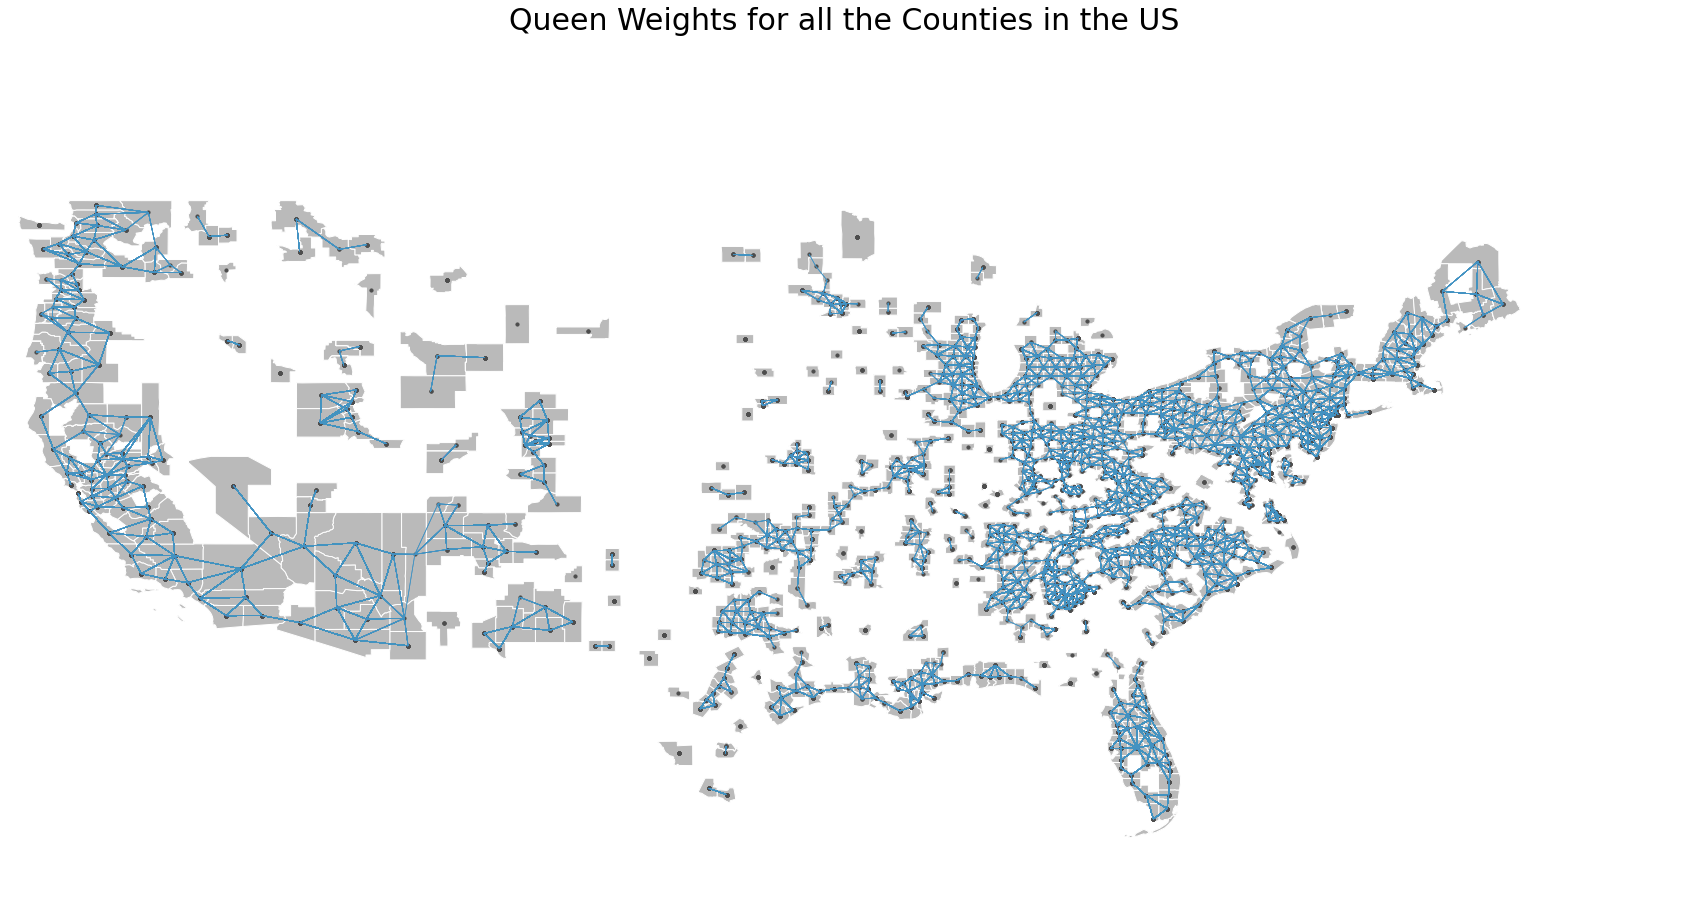

In [160]:
#Now that we have the model we will calculate Morrison I !! 
# we pull out the counties 

stzd_geogon15 = stzd_geogon15.drop(['AGEGRP', 'Crude_Rate', 'SUMLEV'], axis = 1)
stzd_geogon15 = stzd_geogon15.dropna()
stzd_geogon15 = stzd_geogon15.reset_index(drop = True)
w = Queen.from_dataframe(stzd_geogon15)

stzd_geogon15_2 = stzd_geogon15.drop(w.islands)
w2 = Queen.from_dataframe(stzd_geogon15_2)

#subset to just get it for west virgina 



plot_spatial_weights(w, stzd_geogon15, figsize = (30, 30))
plt.title
plt.xlim([-125.17, -60.774])
plt.ylim([21.913, 55.3525])
plt.title('Queen Weights for all the Counties in the US', fontsize = 30)
plt.show()

#put another plot underneath this one for just west. virginia 

This is the equation for Moran's I:

$$I = \frac{n \sum_{i=1}^n \sum_{j=1}^n w_{i,j}z_iz_j}{\sum_{i=1}^n \sum_{j=1}^n w_{i,j} \sum_{i=1}^n z_i^2} $$

- $z_i$ is the deviation of an attribute for feature $i$ from its mean $(x_i - \bar{X})$ and $w_{i,j}$ is the spatial weight between feature $i$ and $j$. 
- $n$ is the total number of features 

In [161]:
y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
moran = esda.Moran(y3, w2)
moran.I

0.4608545578936905

Here our null hypoethsis is that there is no spatial relationship between our different counties. Since the moran's I is positive it shows tha there is SAC relationship that we should take into account. Since we standardized our data the Moran's I will lie between -1 and 1, where 1 is the strongest spatial relationship.

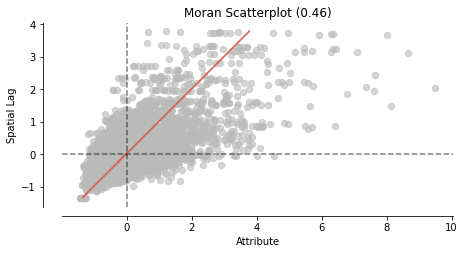

In [162]:
fig, ax = moran_scatterplot(moran, aspect_equal =True)
plt.show()

On the y axis we see the spatial lag mapped to the attribute (where spatial lag is the weighted average of neighboring values). The values in the bottom left and the top right represent that there is a positive spatial association in the data. 

The values in the other quadrants have a negative spatial autocorrelation meaning that value above the mean are surrounded by values below the mean and values below the mean are surrounded by values above the mean. These are considered outliers in terms of the spatial autocorrelation. 

Notes to understand:
- upper right and lower left: positive spatial autocorrelation, cluster of like values, locations are similar to their neighbors 

- lower right and upper left: negative spatial autocorrelation, spatial outliers, locations are different from their neighbors 

The x axis is the standardized cruder rate where zero is the mean, so the x axis shows you the standard deviation. 

- a positive autocorrelation doesn't neccessarily mean that there is a postive auto correlation and that there is a mix between the two. 

The slope in these graphs is the Moran's I value. 

## Now we will look at the local Moran's I 

The
**spatial lag** is a measure of attribute similarity which you can use in conjuction with this idea of spatial similarity. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

So now we are going to plot the local autocorrelations so we can visualize it. 
This local Moran's I essentially remedie this issue of the global Moran's I inability to classify which of the attributes are near each other. 

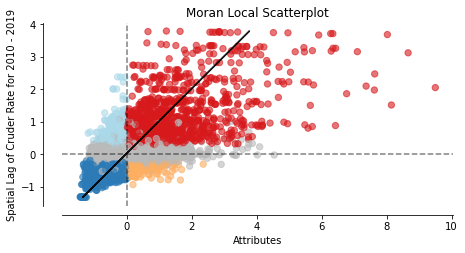

In [164]:
# calculate Moran_Local and plot
moran_loc = esda.moran.Moran_Local(y3, w2)
fig, ax =  splot.esda.moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Attributes')
ax.set_ylabel('Spatial Lag of Cruder Rate for 2010 - 2019')
plt.show()

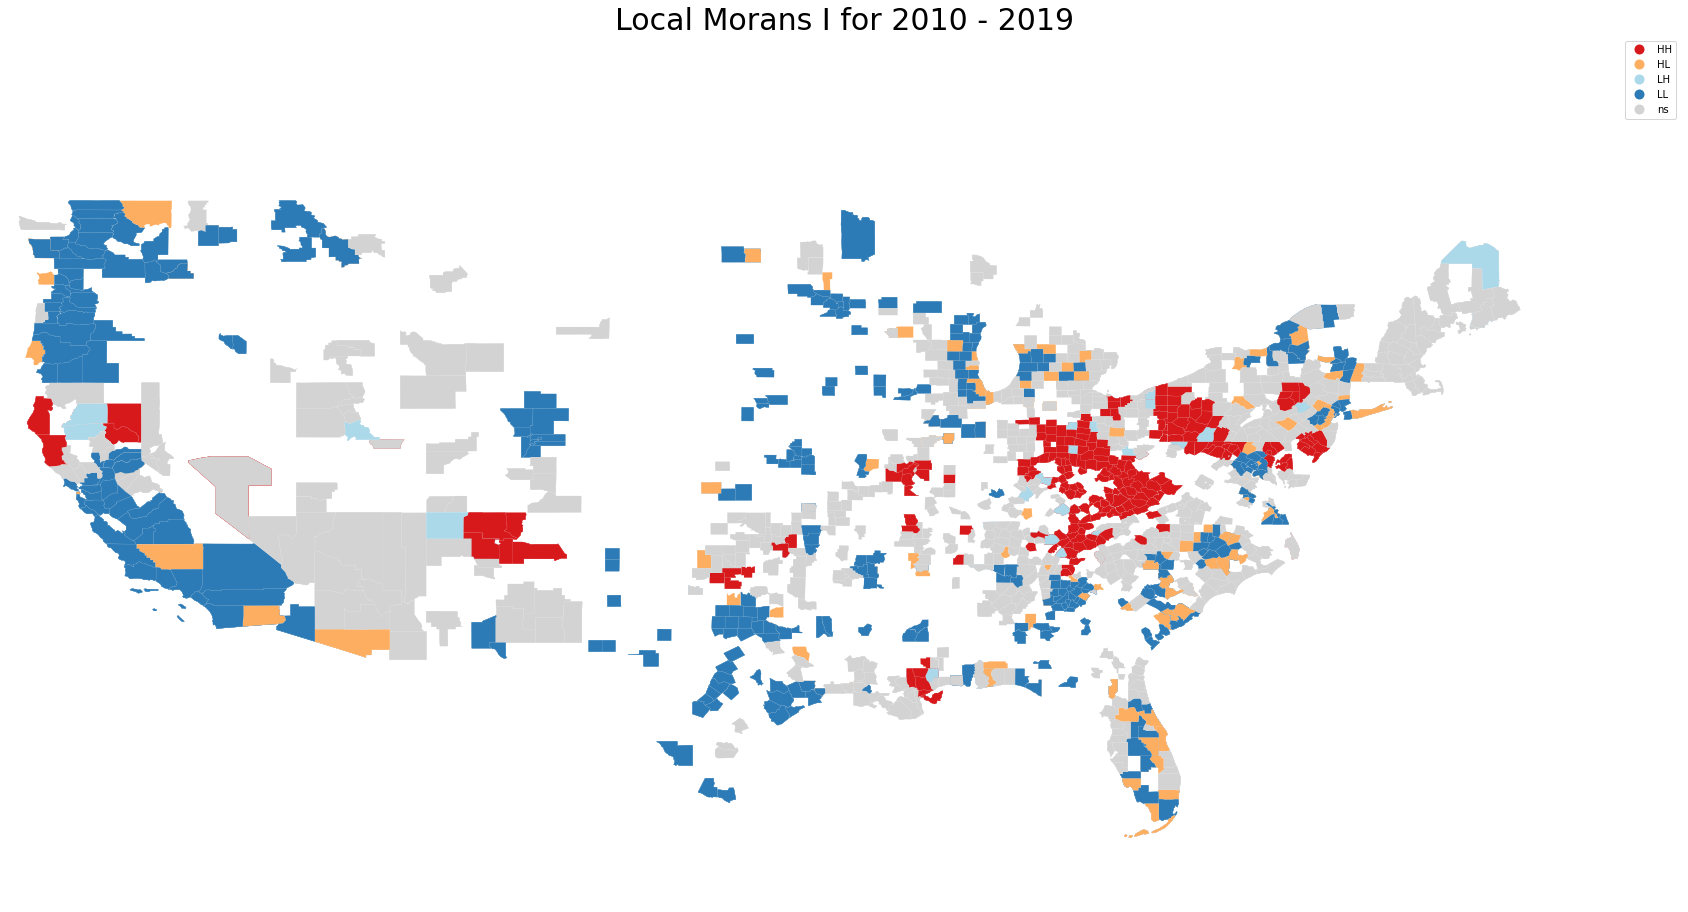

In [165]:
moran_loc = esda.moran.Moran_Local(y3, w2)
splot.esda.lisa_cluster(moran_loc, stzd_geogon15_2, p =0.05, figsize = (30,37))
plt.xlim([-125.17, -60.774])
plt.ylim([21.913, 55.3525])
plt.title('Local Morans I for 2010 - 2019', fontsize = 30)
plt.show()

We will take this into account in our model because when you fit a linear regression model "Regression analysis ignoring these spatial correlations leads to incorrect inference on the estimated regression coefficients by narrowing confidence intervals"(sources: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4343262/) 

/Users/meera/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)
/Users/meera/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


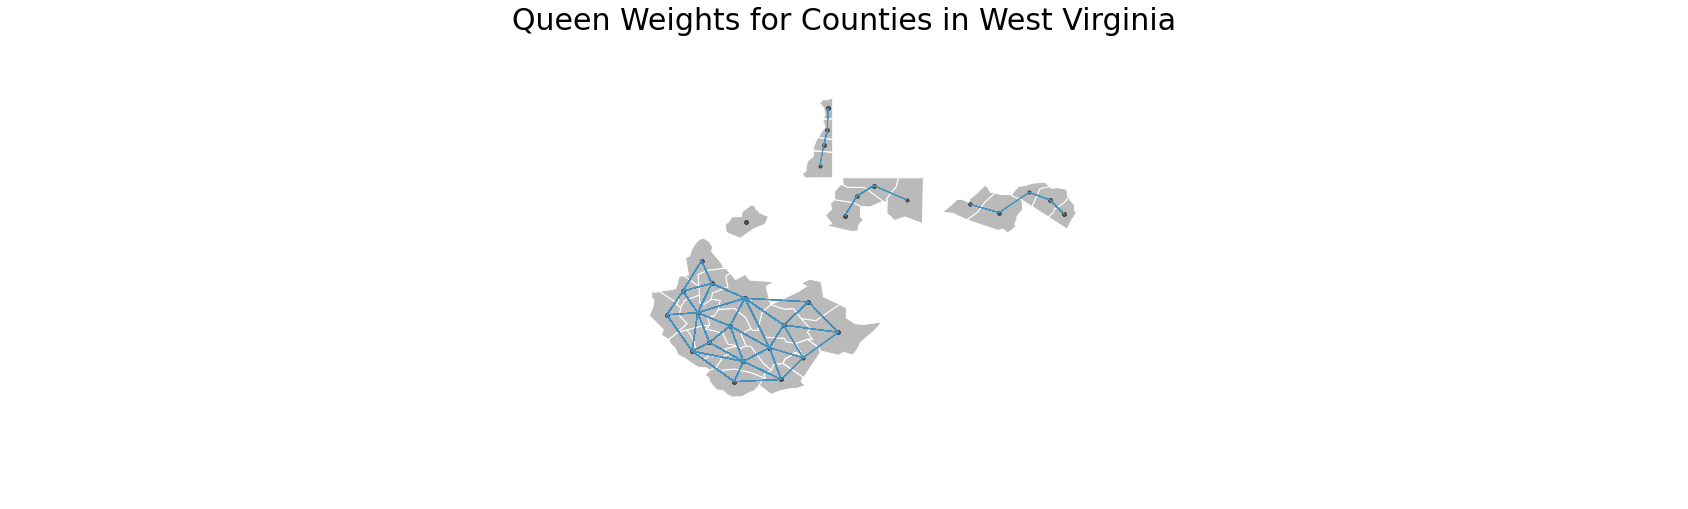

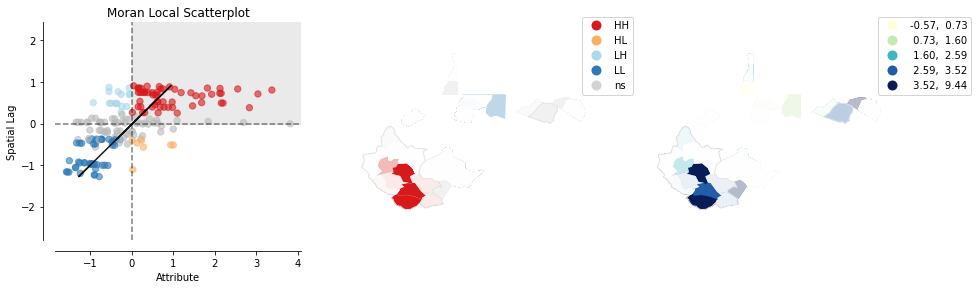

In [167]:
#Making a nice combined

# we are going to focus just on west virginia 
wv_now = stzd_geogon[(stzd_geogon['Year'] >= 2010) & (stzd_geogon['Year'] <= 2019)]
wv_now = wv_now[wv_now['State'] == 'West Virginia']


wv_now = wv_now.drop(['AGEGRP', 'Crude_Rate', 'SUMLEV'], axis = 1)
wv_now = wv_now.dropna()
wv_now = wv_now.reset_index(drop = True)

y = wv_now['Cruder_Rate']

w = Queen.from_dataframe(wv_now)

wv_now_2 = wv_now.drop(w.islands)
w2 = Queen.from_dataframe(wv_now_2)


plot_spatial_weights(w, wv_now, figsize = (30, 30))
plt.title
plt.xlim([-90, -70.774])
plt.ylim([36, 41.3525])
plt.title('Queen Weights for Counties in West Virginia', fontsize = 30)
plt.show()

y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
y3_new = y3.values


# moran = esda.Moran(y3, w2)
# moran.I


w2.transform = 'r'

moran_loc = Moran_Local(y3_new, w2)

fig = plot_local_autocorrelation(moran_loc, wv_now_2, 'Cruder_Rate', p=0.05, quadrant=1)
plt.show()

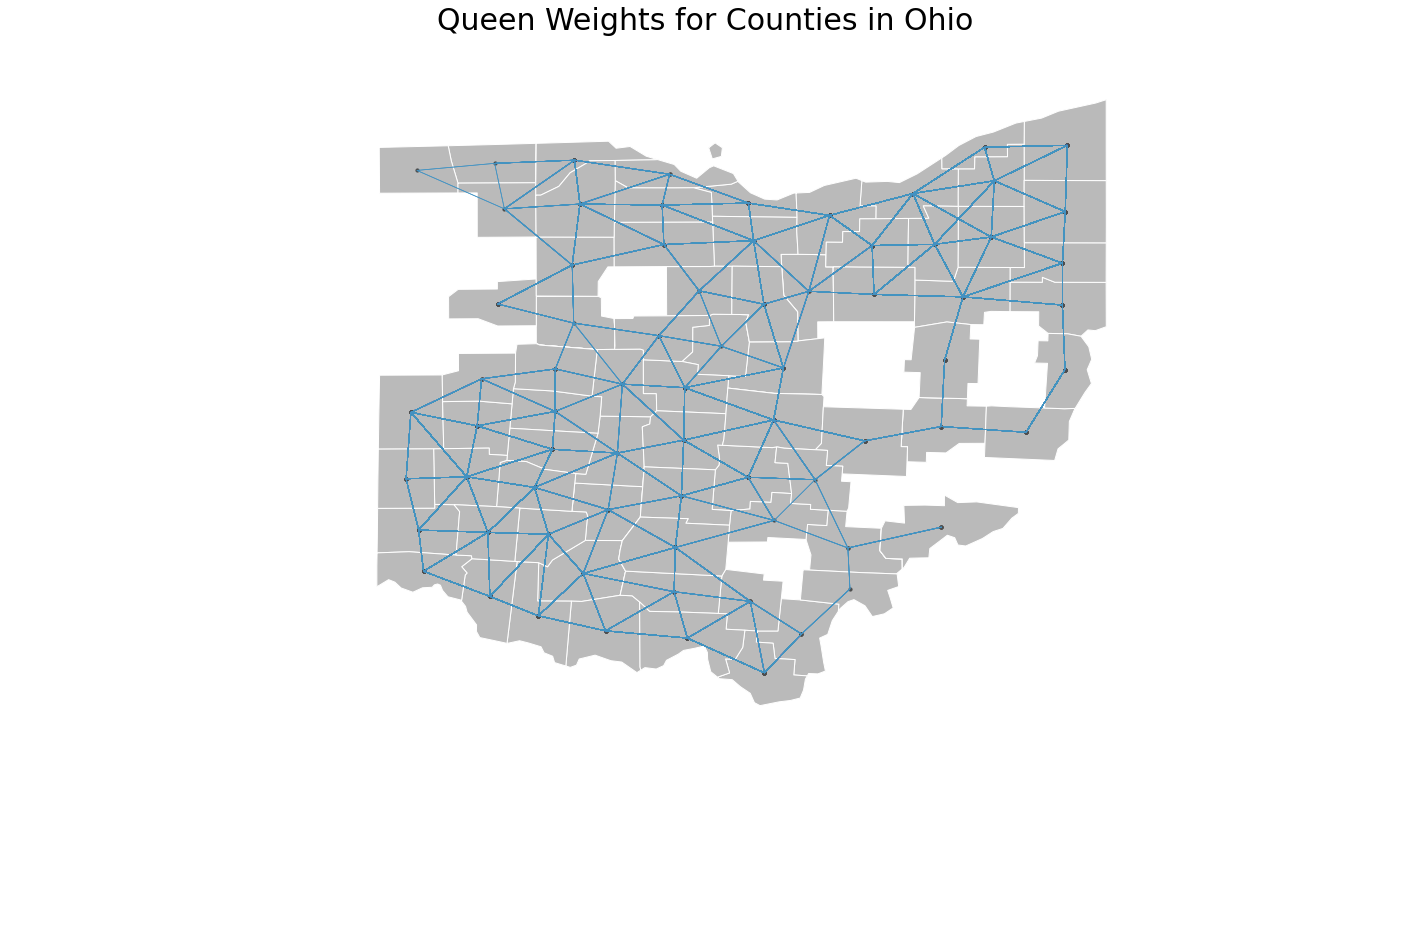

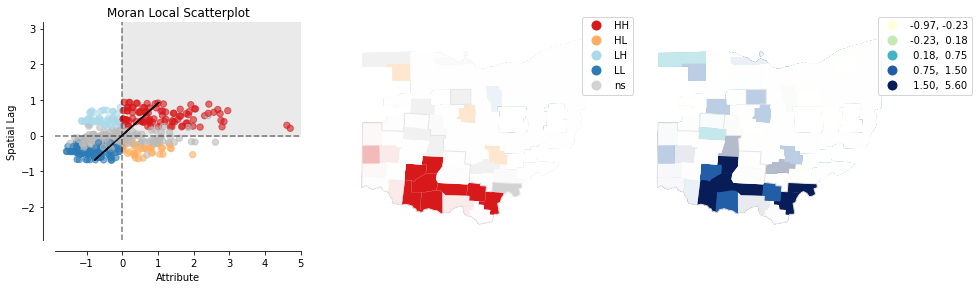

In [179]:
#Making a nice combined

# we are going to focus just on west virginia 
wv_now = stzd_geogon[(stzd_geogon['Year'] >= 2010) & (stzd_geogon['Year'] <= 2019)]
wv_now = wv_now[wv_now['State'] == 'Ohio']


wv_now = wv_now.drop(['AGEGRP', 'Crude_Rate', 'SUMLEV'], axis = 1)
wv_now = wv_now.dropna()
wv_now = wv_now.reset_index(drop = True)

y = wv_now['Cruder_Rate']

w = Queen.from_dataframe(wv_now)

wv_now_2 = wv_now.drop(w.islands)
w2 = Queen.from_dataframe(wv_now_2)


plot_spatial_weights(w, wv_now, figsize = (25, 25))
plt.title
plt.xlim([-87, -78.774])
plt.ylim([37, 42.3525])
plt.title('Queen Weights for Counties in Ohio', fontsize = 30)
plt.show()

y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
y3_new = y3.values


# moran = esda.Moran(y3, w2)
# moran.I


w2.transform = 'r'

moran_loc = Moran_Local(y3_new, w2)

fig = plot_local_autocorrelation(moran_loc, wv_now_2, 'Cruder_Rate', p=0.05, quadrant=1)
plt.show()

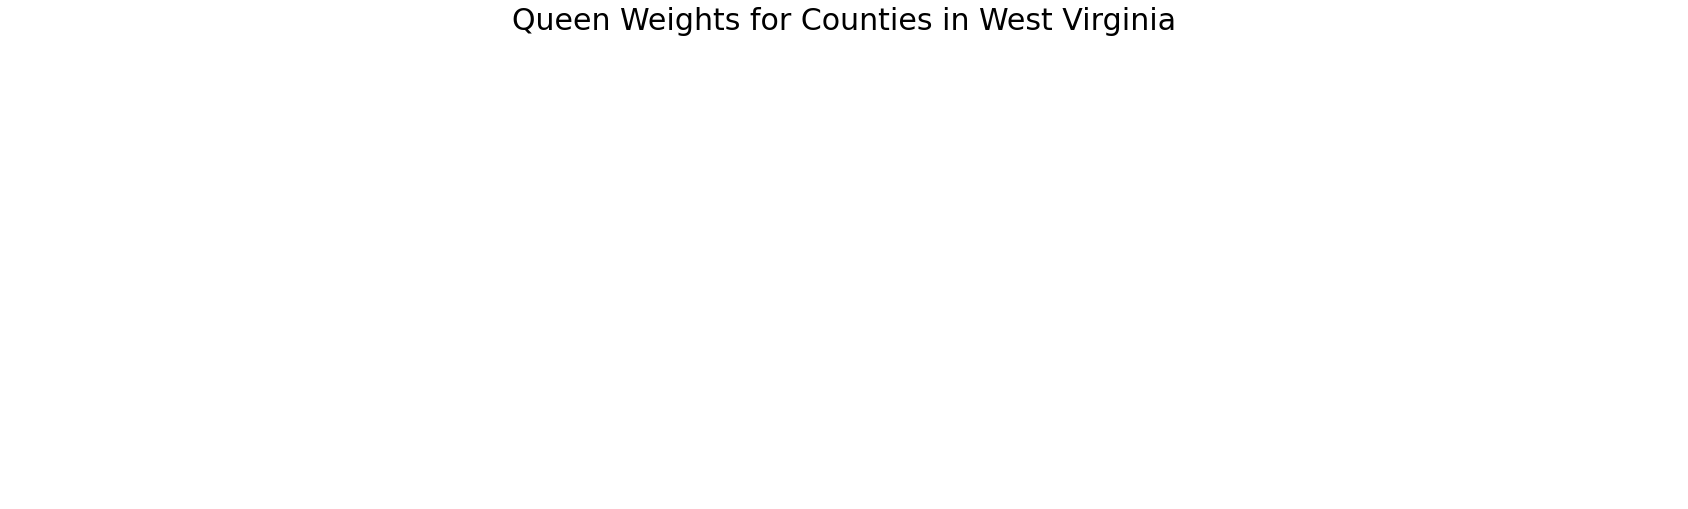

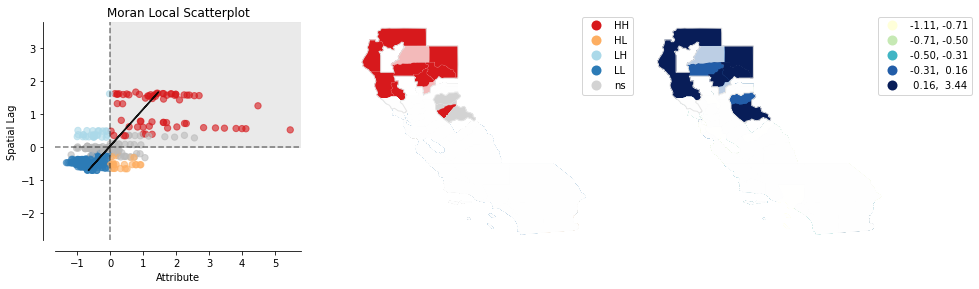

In [169]:
#Making a nice combined

# we are going to focus just on west virginia 
wv_now = stzd_geogon[(stzd_geogon['Year'] >= 2010) & (stzd_geogon['Year'] <= 2019)]
wv_now = wv_now[wv_now['State'] == 'California']


wv_now = wv_now.drop(['AGEGRP', 'Crude_Rate', 'SUMLEV'], axis = 1)
wv_now = wv_now.dropna()
wv_now = wv_now.reset_index(drop = True)

y = wv_now['Cruder_Rate']

w = Queen.from_dataframe(wv_now)

wv_now_2 = wv_now.drop(w.islands)
w2 = Queen.from_dataframe(wv_now_2)


plot_spatial_weights(w, wv_now, figsize = (30, 30))
plt.title
plt.xlim([-90, -70.774])
plt.ylim([36, 41.3525])
plt.title('Queen Weights for Counties in West Virginia', fontsize = 30)
plt.show()

y2 = y.reset_index(drop = True)
y3 = y2.drop(w.islands)
y3_new = y3.values


# moran = esda.Moran(y3, w2)
# moran.I


w2.transform = 'r'

moran_loc = Moran_Local(y3_new, w2)

fig = plot_local_autocorrelation(moran_loc, wv_now_2, 'Cruder_Rate', p=0.05, quadrant=1)
plt.show()